In [1]:
import tempfile
import pandas as pd
pd.set_option('display.max_rows', 100)

import numpy as np
import os
from tqdm import tqdm
from glob import glob
from datetime import timedelta
import datetime

In [174]:
# Make a synthesized dataframe for gt and predict

df_PSG = pd.DataFrame({
    'linetime': pd.date_range(start='2017-01-04 1:00:00', end = '2017-01-04 3:00:00', freq='30S')
})

df_predict = pd.DataFrame({
    'linetime': pd.date_range(start='2017-01-04 1:00:00', end = '2017-01-04 3:00:00', freq='30S')
})

"""
# Add labels wake:0/sleep:1 --> lets assume sleep labels are anomalies!
# Adding 2 sleep periods [1:30_1:50, 2:30_2:45]
"""

df_PSG ['w/s'] = 0
df_predict ['w/s'] = 0

#define sleep periods for PSG
i = 60
j = 100
for c in range(i, j+1):
    df_PSG.at[c, 'w/s'] = 1
    
i = 180
j = 210
for c in range(i, j+1):
    df_PSG.at[c, 'w/s'] = 1
# df_PSG.loc[99:103]


# define sleep periods for prediction
i = 70
j = 110
for c in range(i, j+1):
    df_predict.at[c, 'w/s'] = 1

i = 170
j = 200
for c in range(i, j+1):
    df_predict.at[c, 'w/s'] = 1
    


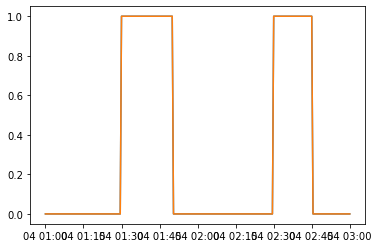

In [175]:
import matplotlib.pyplot as plt

plt.plot(df_PSG['linetime'], df_PSG['w/s'])
plt.plot(df_predict['linetime'], df_predict['w/s'])

In [176]:
# make a list of indexes that shows sleep(or anomaly) in prediction labels
predicted_anomaly_ranges = []
temp = []

for i in range(len(df_predict)):
    if(df_predict.loc[i,'w/s'] == 1):
        temp.append(i)
        
        if(df_predict.loc[i+1,'w/s'] != 1):
            predicted_anomaly_ranges.append(temp)
            temp = []
            continue;

            
# make a list of indexes that shows sleep(or anomaly) in GT labels
real_anomaly_range = []
temp = []

for i in range(len(df_PSG)):
    if(df_PSG.loc[i,'w/s'] == 1):
        temp.append(i)
        
        if(df_PSG.loc[i+1,'w/s'] != 1):
            real_anomaly_range.append(temp)
            temp = []
            continue;

In [177]:
#real_anomaly_range

In [178]:
#assuming we have no bias
bias = 1


def w(r, overlap_set, bias = 1):
    max_val = 0
    my_val = 0
    
    for i in range(len(r)):
        max_val = max_val + bias
        if(r[i] in overlap_set):
            my_val = my_val + bias
            
    return my_val/max_val
    #usage: w([2,3,4,5], [4,5]) --> returns 0.5 

    
    
#lets assume gamma function in the simplest way
def gamma(x):
    return 1/x



#recall_cardinality factor
def recall_cardinality_factor(r, predicted_anomaly_ranges):
    x = 0
    if(r in predicted_anomaly_ranges):
        return 1
    else:
        #  lets figure out that how many predicted ranges including r elements
        for predict in predicted_anomaly_ranges:
            if (any(i in r for i in predict) ):
                x += 1
        
        return gamma(x)
        #usage: recall_cardinality_factor([2,3,4], [[1,2], [3,5,6], [0,8]]) --> returns 0.5
    
    
# recall_overlap_reward
def recall_overlap_reward(r, predicted_anomaly_ranges):
    cardinality = recall_cardinality_factor(r, predicted_anomaly_ranges)
    sum_weight = 0
    
    for predict in predicted_anomaly_ranges:
        
        overlap_set = list(set(predict) & set(r)) #calculate overlap_set for r with prediction 
        weight = w(r, overlap_set, bias = 1)
        sum_weight = sum_weight + weight 
        
    return cardinality*sum_weight
    #usage recall_overlap_reward([2,3,4,0,8], [[1,2], [3,5,6], [0,8]]) --> returns 0.26
    

In [179]:
def existence_reward(r, predicted_anomaly_ranges):
#first make a unify list for all ranges to check for availability of r in it
    all_predict = []
    cnt = 0
    for i in range(len(predicted_anomaly_ranges)):
        all_predict.extend(predicted_anomaly_ranges[i])
    
    for i in range(len(r)):
        #if that value exist in anomaly detection. the counter will be increased
        if (r[i] in all_predict):
            cnt += 1
    if(cnt == len(r)):
        return 1
    else:   
        return 0
    #usage: existence_reward([2,3,4,5], [[1,2], [4,5,6]]) --> return 0
        #   existence_reward([2,3,4,5], [[1,2], [3,4,5,6]]) --> return 1
        

        
        
alpha = 0.5 #relative importance of rewarding existence
# we can tune it later

def recall(real_anomaly_range, predicted_anomaly_ranges, alpha= 0.5):
    total_recall = 0 
    for r in real_anomaly_range:
        recall_r = ( alpha*existence_reward(r, predicted_anomaly_ranges) ) + ( (1-alpha)*recall_overlap_reward(r, predicted_anomaly_ranges))     
        total_recall = total_recall + recall_r
        
    return total_recall/len(real_anomaly_range)
    # usage: recall([[1,2,3,4], [10,11,12]], [[1,2], [3,5,6], [8,9], [10,11]], alpha = 0.5) --> returns 0.17
        
        
        

In [180]:
recall(real_anomaly_range, predicted_anomaly_ranges, alpha= 0.5)


1.0

# Precision 

In [186]:
## Do I have to continue???

#precision_cardinality factor
def precision_cardinality_factor(p, real_anomaly_range):
    x = 0
    if(p in real_anomaly_range):
        return 1
    else:
        #  lets figure out that how many of real ranges including p elements
        for real in real_anomaly_range:
            if (any(i in p for i in real) ):
                x += 1
        
        return gamma(x)
        #usage: recall_cardinality_factor([2,3,4], [[1,2], [3,5,6], [0,8]]) --> returns 0.5
    
    
# recall_overlap_reward
def precision_overlap_reward(p, real_anomaly_range):
    cardinality = precision_cardinality_factor(p, real_anomaly_range)
    sum_weight = 0
    
    for real in real_anomaly_range:
        
        overlap_set = list(set(real) & set(p)) 
        weight = w(p, overlap_set, bias = 1)
        sum_weight = sum_weight + weight 
        
    return cardinality*sum_weight
    #usage recall_overlap_reward([2,3,4,0,8], [[1,2], [3,5,6], [0,8]]) --> returns 0.26
    

In [187]:
# def precision(real_anomaly_range, predicted_anomaly_ranges, alpha= 0.5):
#     total_precision = 0 
#     for p in predicted_anomaly_ranges:
#         precision_cardinality = precision_cardinality_factor(p, real_anomaly_range)
#         precision_p = recall_overlap_reward
#         total_precision = total_precision + precision_p
        
#     return total_precision/len(predicted_anomaly_ranges)
